In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras as kr
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM

In [3]:
j_return=pd.read_csv("LSTM_data/j_return.csv")

In [4]:
train_data = j_return[:11479]
# train_data
x_train = np.zeros((22075,1,12))
y_train = np.zeros((22075,1))
y_train_label = np.zeros((22075,1))
for i in range(25):
    temp = train_data["p"+str(i+1)].tolist()
    for j in range(len(temp)//13):
        x_train[i*883+j]=temp[j*13:j*13+12]
        y_train_label[i*883+j]= 0 if temp[j*13+12]<0.0 or temp[j*13+12]==0.0 else 1
        y_train[i*883+j]= temp[j*13+12]



test_data = j_return[11479:]
# train_data
x_test = np.zeros((6400,1,12))
y_test = np.zeros((6400,1))
y_test_label = np.zeros((6400,1))
test_date = []
for i in test_data.week_date:
    if i!=0:
        test_date.append(str(int(i)))
    else:
        continue
for i in range(25):
    temp = test_data["p"+str(i+1)].tolist()
    for j in range(len(temp)//13):
        x_test[i*256+j]=temp[j*13:j*13+12]
        y_test_label[i*256+j]= 0 if temp[j*13+12]<0.0 or temp[j*13+12]==0.0 else 1
        y_test [i*256+j]= temp[j*13+12]
        
        
#写一个LossHistory类，保存loss和acc
class LossHistory(kr.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        #self.val_loss = {'batch':[], 'epoch':[]}
        #self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('binary_accuracy'))
        #self.val_loss['batch'].append(logs.get('val_loss'))
        #self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('binary_accuracy'))
        #self.val_loss['epoch'].append(logs.get('val_loss'))
        #self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()
        
        
        


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1, 100)            1300      
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 52)             31824     
_________________________________________________________________
lstm_7 (LSTM)                (None, 52)                21840     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               5300      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 60,365
Trainable params: 60,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22075/22075 [==============================] - 4s 196us/step - loss: 0.0021
Epoch 2/20
22075/22075 [=====

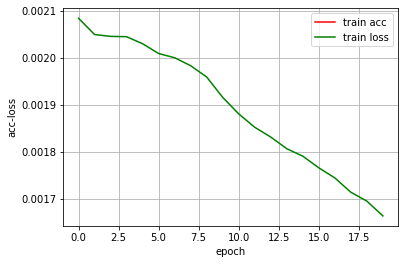

In [12]:
history = LossHistory()
LSTMmodel = Sequential([
    Dense(100, input_shape = (1,12),activation = "tanh"),
    LSTM(52,activation="tanh",return_sequences=True),
    LSTM(52,activation="tanh",return_sequences=False),
    Dense(100,activation = "tanh"),
    Dense(1,activation = "tanh")
    ])
LSTMmodel.compile(optimizer = "adam",loss = "mse")
LSTMmodel.summary()



LSTMmodel.fit(x_train,
          y_train,
          epochs=20,
          callbacks=[history]
         )
history.loss_plot('epoch')

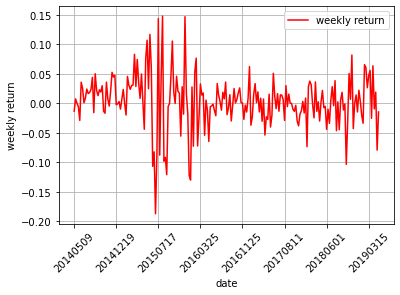

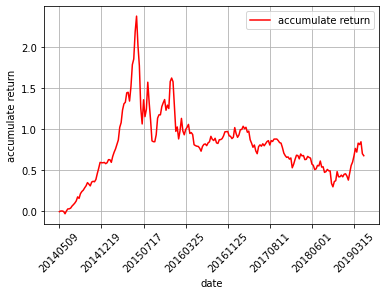

0.6707043424169752
0.1054397532527993


In [13]:
x_axis = test_date.copy()
y_pred = LSTMmodel.predict(x_test)
#将预测到的数据码成表格，25列
row_num = len(y_pred)//25
ls = list(range(row_num))
df_pred = pd.DataFrame({"order":ls})
for i in range(25):
    df_pred["p"+str(i+1)] =y_pred[i*row_num:i*row_num+row_num]
df_pred.drop("order",axis = 1,inplace = True)
#测试数据，也就是持有期的实际收益码成表格，25列
df_test = pd.DataFrame({"order":ls})
for i in range(25):
    df_test["p"+str(i+1)] =y_test[i*row_num:i*row_num+row_num]
df_test.drop("order",axis = 1,inplace = True)
#根据每一行的y_pred,得到大于0.5的位置，买入y_test里面对应位置且最大的5个收益率
rate = []
for i in range(row_num):
    row = df_pred.loc[i].tolist()
    temp = []
    for k in range(5):
        if max(row)>0.0:
            large = row.index(max(row))
            temp.append(large)
            row[row.index(max(row))] = -1
        else:
            break
    average = 0.0
    for j in temp:
        average += df_test.loc[i].tolist()[j]
    if len(temp)==0:
        x_axis[i]=0
        continue
    else:
        average /= len(temp)
        rate.append(average)
for i in range(x_axis.count(0)):
        x_axis.remove(0)
#计算累计收益率
#画图
tick_spacing=30
fig, ax = plt.subplots(1,1)
ax.plot(x_axis,rate, 'r', label="weekly return")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.grid(True)
plt.xlabel("date")
plt.ylabel('weekly return')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()



accumulate = rate
order = range(len(accumulate))
for i in order[1:]:
    accumulate[i] = (accumulate[i]+1)*(accumulate[i-1]+1)-1
    
    
    
    
#画图
tick_spacing=30
fig, ax = plt.subplots(1,1)
ax.plot(x_axis,accumulate, 'r', label="accumulate return")
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.grid(True)
plt.xlabel("date")
plt.ylabel('accumulate return')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

print(accumulate[-1])
print(np.power(accumulate[-1]+1,25/128)-1)
